# Semantic Textual Similarity

Authors: Adrián Tormos Llorente and Ferran Agulló López

In [20]:
# required imports
from auxiliary_code.file_methods import load_train_data, load_test_data
from auxiliary_code.preprocessing_steps import Preprocessing
from auxiliary_code.sentence_similarity_metrics import SentenceSimilarity
from auxiliary_code.aggregation_methods import AggregationMethodFactory
from auxiliary_code.visualize import show_correlation_plot, show_scatter_plot
from scipy.stats import pearsonr

# Approach

Our approach contains the next three different steps:

- Preprocessing: in this step we run different methods like tokenization and punctuation removal to prepare the data for the following steps.
- Similarity metrics computation: in this step we compute a set of similarity metrics between the sentences like word n-gram jaccard similarity and wordnet pairwise word similarity.
- Aggregation method: in this step we group the prior similarity metrics with a method like random forest or a support vector machine to obtain a final score to compute the correlation with the gold standard.

In the presentation we will precisely explain all the preprocessing steps, similarity metrics and aggregation methods we have tested. In this notebook we have included the code to run the configuration with which we have obtained the best correlation score -> 0.7685. Nevertheless, it is very easy to use other configurations because we use a Json object to define all the parameters of each experiment. In this way, it is only necessary to modify the json object to change the experiment configuration without touching any code. 

Follows the Json object that defines the experiment configuration with which we have obtained the highest score

In [3]:
config = {
    "preprocessing_steps": [
        {"name": "lower_case"},
        {"name": "word_tokenize"},
        {"name": "punctuation_removal"},
        {"name": "pos_tagging"},
        {"name": "lemmatization"},
        {"name": "word_sense_disambiguation"}
    ],
    "similarity_metrics": [
        {"name": "jaccard_similarity"},
        {"name": "jaccard_similarity_stemmer"},
        {"name": "cosine_similarity_tfidf"},
        {"name": "ngram_overlap_weighted", "n": 1, "filter": "none"},
        {"name": "ngram_overlap", "n": 2, "filter": "none"},
        {"name": "ngram_overlap", "n": 3, "filter": "none"},
        {"name": "ngram_overlap", "n": 1, "filter": "content"},
        {"name": "ngram_overlap", "n": 2, "filter": "content"},
        {"name": "ngram_overlap", "n": 3, "filter": "content"},
        {"name": "ngram_overlap", "n": 4, "filter": "content"},
        {"name": "ngram_overlap", "n": 1, "filter": "stopwords"},
        {"name": "ngram_overlap", "n": 2, "filter": "stopwords"},
        {"name": "ngram_overlap", "n": 3, "filter": "stopwords"},
        {"name": "ngram_overlap", "n": 4, "filter": "stopwords"},
        {"name": "ngram_overlap", "n": 5, "filter": "stopwords"},
        {"name": "pos_ngram_overlap", "n": 1},
        {"name": "pos_ngram_overlap", "n": 2},
        {"name": "character_ngram_overlap", "n": 2},
        {"name": "character_ngram_overlap", "n": 3},
        {"name": "character_ngram_overlap", "n": 4},
        {"name": "character_ngram_overlap", "n": 5},
        {"name": "character_ngram_overlap", "n": 6},
        {"name": "character_ngram_overlap", "n": 7},
        {"name": "character_ngram_overlap", "n": 8},
        {"name": "character_ngram_overlap", "n": 9},
        {"name": "sentence_length_difference"},
        {"name": "wordnet_pairwise_word_similarity", "metric": "lch"},
        {"name": "wordnet_pairwise_word_similarity", "metric": "path"},
        {"name": "wordnet_pairwise_word_similarity_weighted", "metric": "lch"},
        {"name": "wordnet_pairwise_word_similarity_weighted", "metric": "path"},
        {"name": "wordnet_pairwise_word_similarity_weighted_all_possibilities", "metric": "path"},
        {"name": "number_overlap"},
        {"name": "longest_common_subsequence", "mode": "substring"}
    ],
    "aggregation_method": {"name": "voting"}
}

There are other examples of configuration Jsons in the directory with path ./input/config_examples attached along this notebook.

Lastly, it must be said that in this notebook we call a lot of functions that are defined in files inside the directory ./auxiliary_code. We think this increases a lot the legibility and helps to better understand the approach.

# Experiment run

In this section we run the experiment with the highest score. But as we have said before, it is not necessary to change the code below to test different configurations only the json object we haved shown earlier.

For any problems running the code we have attached a README file with the necessary information about it.

### Load data

We load the train and test data

In [5]:
train_sentence_pairs, train_labels = load_train_data()
test_sentence_pairs, test_labels = load_test_data()
print('Train values length: ' + str(len(train_sentence_pairs)) + '; Train labels length: ' + str(len(train_labels)))
print('Test values length: ' + str(len(test_sentence_pairs)) + '; Test labels length: ' + str(len(test_labels)))

Train values length: 2234; Train labels length: 2234
Test values length: 3108; Test labels length: 3108


### Preprocessing

We do the preprocessing of the train and test data

In [6]:
preprocessing = Preprocessing(config['preprocessing_steps'])
train_output = preprocessing.do_pipeline(train_sentence_pairs)
test_output = preprocessing.do_pipeline(test_sentence_pairs)

We show some sentences:

In [8]:
def pretty_print_sentence(sentence):
    labels = ['Original sentence', 'Sentence transformation', 'Tokens', 'Pos tags', 'Synsets']
    for index, data in enumerate(sentence):
        print('\n' + labels[index] + ': ' + str(data))

print('\nSentence 1')
pretty_print_sentence(train_output[0][0])
print('\n\nSentence 2')
pretty_print_sentence(train_output[0][1])


Sentence 1

Original sentence: But other sources close to the sale said Vivendi was keeping the door open to further bids and hoped to see bidders interested in individual assets team up.

Sentence transformation: but other sources close to the sale said vivendi was keeping the door open to further bids and hoped to see bidders interested in individual assets team up.

Tokens: ['but', 'other', 'source', 'close', 'to', 'the', 'sale', 'say', 'vivendi', 'be', 'keep', 'the', 'door', 'open', 'to', 'further', 'bid', 'and', 'hop', 'to', 'see', 'bidder', 'interested', 'in', 'individual', 'asset', 'team', 'up']

Pos tags: ['CC', 'JJ', 'NNS', 'RB', 'TO', 'DT', 'NN', 'VBD', 'NN', 'VBD', 'VBG', 'DT', 'NN', 'JJ', 'TO', 'JJ', 'NNS', 'CC', 'VBD', 'TO', 'VB', 'NNS', 'JJ', 'IN', 'JJ', 'NNS', 'VBP', 'RP']

Synsets: ['but', 'other', Synset('reservoir.n.04'), Synset('near.r.01'), 'to', 'the', Synset('sale.n.05'), Synset('state.v.01'), 'vivendi', Synset('equal.v.01'), Synset('retain.v.02'), 'the', Synset(

As we can see, we save the next information for each sentence:
- The original sentence
- The original sentence after the transformations done to the full sentence
- The sentence tokens
- The tokens' pos tags
- The tokens' synsets

In this way, the similarity metrics can access to the required information from each sentence.

### Similarity metrics computation

We compute the multiple similarity metrics for the train and test sentence pairs

In [9]:
sentence_similarity = SentenceSimilarity(config['similarity_metrics'])
metric_train_values = sentence_similarity.compute_pair_comparison(train_output)
metric_test_values = sentence_similarity.compute_pair_comparison(test_output)

We show the correlation matrix between all the metrics for the train set. The last line and column contain the gold standard so we can check the correlation of all the metrics with the gold standard. There are some metrics that appear with the same name but they appear in the same order as they appeared in the config Json object.

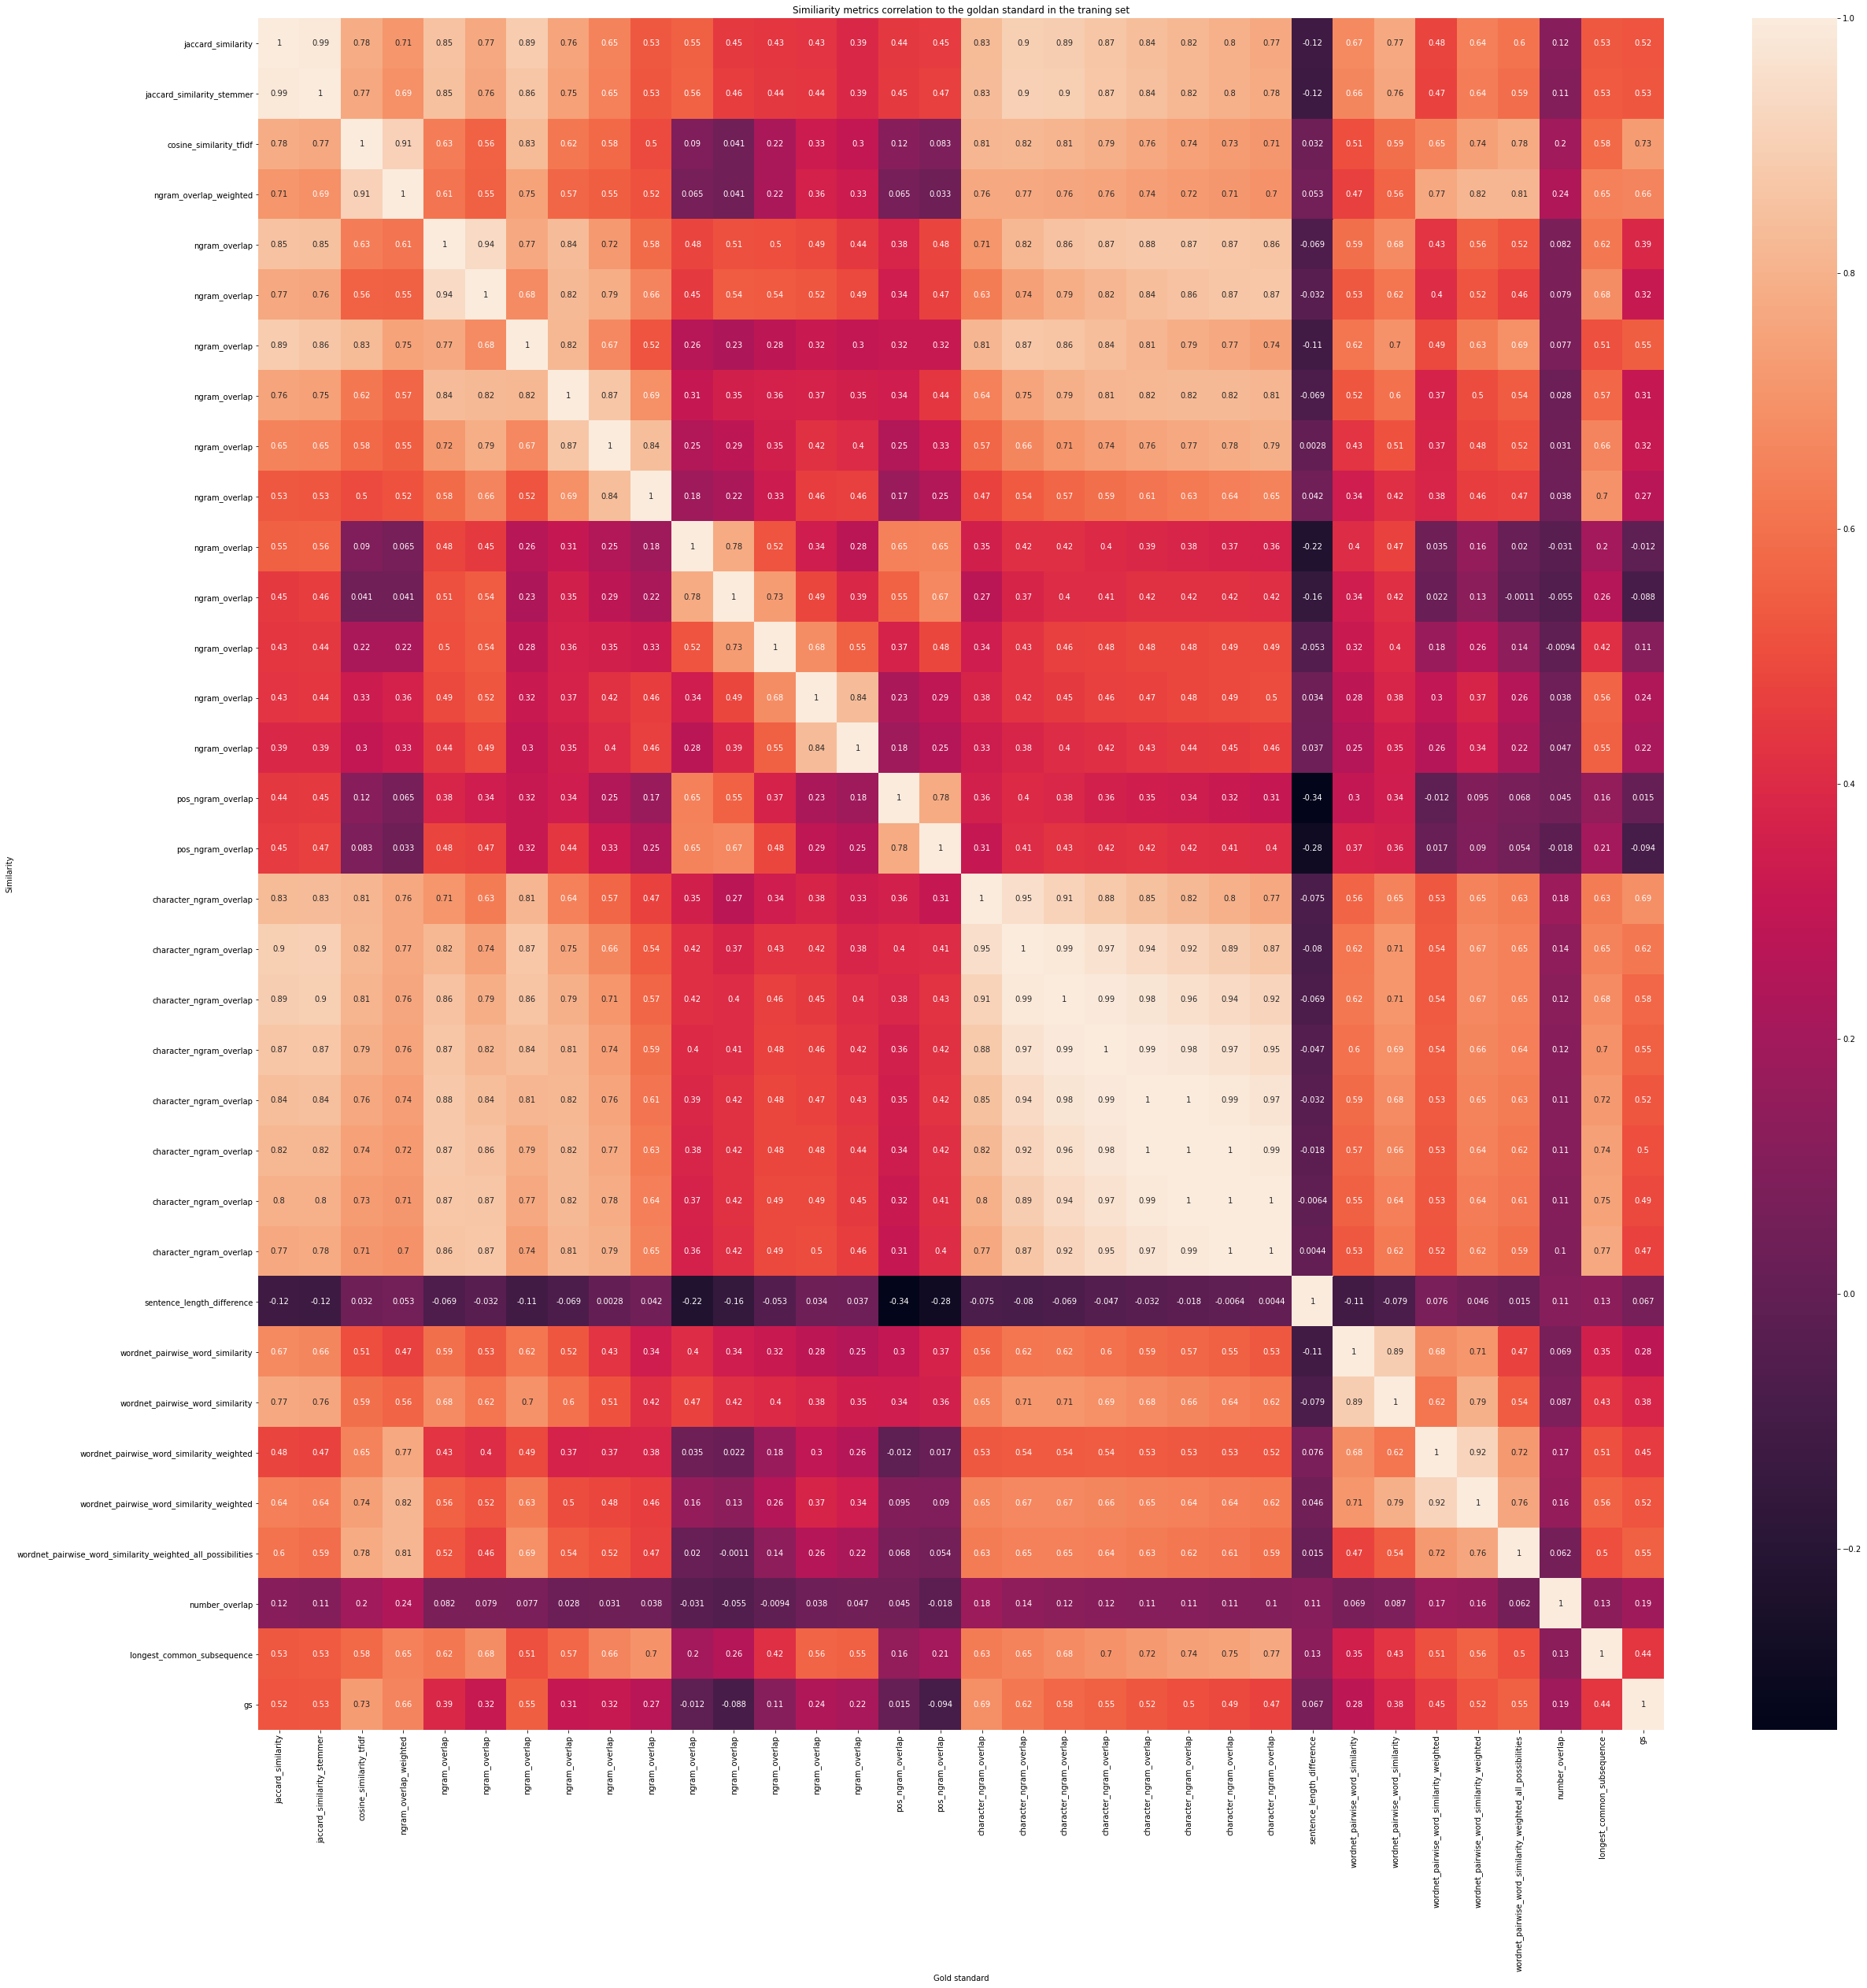

In [18]:
show_correlation_plot(config['similarity_metrics'], train_labels, metric_train_values,
                      'Similiarity metrics correlation to the goldan standard in the traning set', None)

We can extract a lot of conclusions, but the main ones are (the full conclusions will be explained in the presentation):

- The best metrics in order are (with the best correlation with the gold standard): 
    - Tf-idf with cosine similarity
    - Char 2-gram with jaccard similarity
    - Char 3-gram with jaccard similarity
    - Word 1-gram weighted with jaccard similarity (weighted with the idf mean of the sentence words)
- There are some metrics with almost no correlation witht he gold standard as:
    - Word 1/2-gram jaccard similarity wihout stopwords
    - Pos n-gram overlap
    - Sentence length difference
- All the metrics of character n-gram are very correlated between them, they have very similar information

### Aggregation method

We run the aggregation method, in this case a voting method with multiple classifiers. We train the method with the train data and predict the score for the test data.

In [16]:
aggregation_method = AggregationMethodFactory.select_aggregation_method(config, metric_train_values, train_labels, metric_test_values, None)
train_results = aggregation_method.train()
test_results = aggregation_method.test()

### Correlation with the gold standard

Now we do the Pearson correlation with the gold standard for the two sets for the results obtained from the aggregation method.

In [17]:
print('Correlation with Gold standard in the training set')
print(pearsonr(train_labels, train_results)[0])
print('\nCorrelation with Gold standard in the testing set')
print(pearsonr(test_labels, test_results)[0])

Correlation with Gold standard in the training set
0.9453996122836337

Correlation with Gold standard in the testing set
0.7685853256361652


As we can see, although we obtain a very good result in the testing set, we suffer from a lot of overfitting; we obtain a much higher score in the training set. This can be produced for the decompensated size of the testing set compared to the training set.

Lastly, we show a scatter plot for the two sets

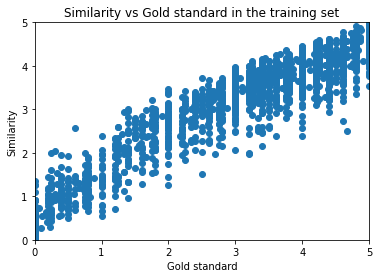

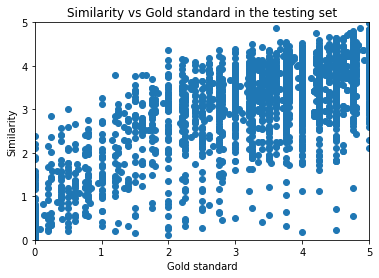

In [22]:
show_scatter_plot(train_labels, train_results, 'Similarity vs Gold standard in the training set', None)
show_scatter_plot(test_labels, test_results, 'Similarity vs Gold standard in the testing set', None)

As we can see, in the training set we obtain a very good distribution. However, in the testing set we have a lot of noise (a lot of points not quite with the same value in the gold standard and in our resulting score).